R: a=val b=val c

a u + b du/dt = c

2.1430943857780775 0.02040816326530612


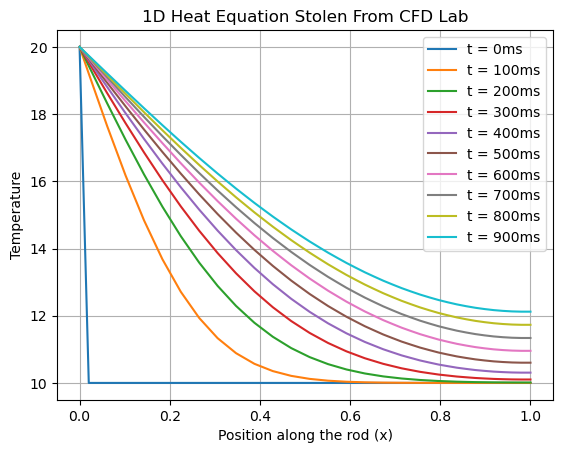

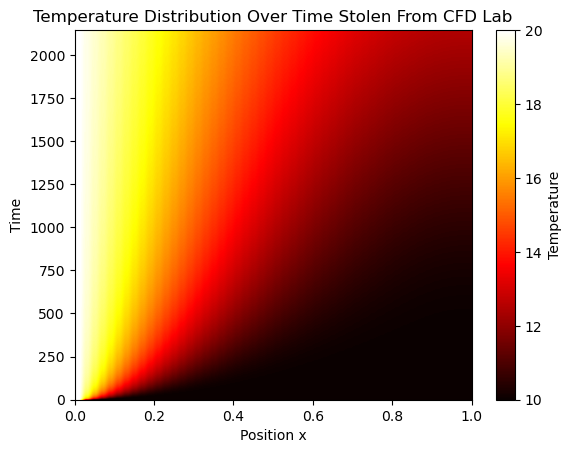

In [46]:
import numpy as np
from numpy import sin, cos, exp, pi
import matplotlib.pyplot as plt

def read_file(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines:
        line = line.strip()
        if not line.startswith('#') and line: 
            data.append(line)
    return data

params_data = read_file('params.dat')
rhs_data = read_file('rhs.dat')
bc_data = read_file('bc.dat')
init_data = read_file('init.dat')

# Parse params.dat
Nx = int(params_data[0].split('=')[1].strip())
time_iter = int(params_data[1].split('=')[1].strip())
batch = int(params_data[2].split('=')[1].strip())
L = float(params_data[3].split('=')[1].strip())

k1 = float(params_data[4].split('=')[1].strip())
cp1 = float(params_data[5].split('=')[1].strip())
rho1 = float(params_data[6].split('=')[1].strip())
a1 = k1 / (cp1 * rho1)

# Parse rhs.dat
rhs_function = rhs_data[0].strip()

# Parse bc.dat
left_bc = bc_data[0].split(':')[1].strip() 
right_bc = bc_data[1].split(':')[1].strip()
left_type = bc_data[0].split(':')[0].strip()
right_type = bc_data[1].split(':')[0].strip()

# Parse init.dat
T_init = float(init_data[0].split('=')[1].strip())

def f(x):
    return eval(rhs_function)


x = np.linspace(0, L, Nx)
dx = L / (Nx - 1)
dt = 0.5 * dx**2 / a1

print(dt, dx)
# Main function
def heat_1D(Nx=Nx, L=L, time_iter=time_iter, batch=batch):
    
    
    u = np.full_like(x, T_init) + f(x)
    u_new = np.zeros_like(u)
    u_all = np.zeros((time_iter, Nx))
    

    # Parse Robin
    if left_type == 'R':
        left_params = left_bc.split()
        a_left = float(left_params[0].split('=')[1])
        b_left = float(left_params[1].split('=')[1])
        c_left = float(left_params[2])

    if right_type == 'R':
        right_params = right_bc.split()
        a_right = float(right_params[0].split('=')[1])
        b_right = float(right_params[1].split('=')[1])
        c_right = float(right_params[2])

    for t in range(time_iter):
        for i in range(1, Nx - 1):
            u_new[i] = (k1 / (cp1 * rho1)) * dt / dx**2 * (u[i+1] - 2 * u[i] + u[i-1]) + u[i] + dt * f(i) / (cp1 * rho1)

        if left_type == 'D':  # Dirichlet
            u_new[0] = left_bc
        elif left_type == 'N':  # Neumann
            u_new[0] = u_new[1]
        elif left_type == 'R':  # Robin
            u_new[0] = (c_left * dx + b_left * u_new[1]) / (a_left * dx + b_left)

        if right_type == 'D':  # Dirichlet
            u_new[-1] = right_bc
        elif right_type == 'N':  # Neumann
            u_new[-1] = u_new[-2]
        elif right_type == 'R':  # Robin
            u_new[-1] = (c_right * dx + b_right * u_new[-2]) / (a_right * dx + b_right)

        u = u_new.copy()
        u_all[t, :] = u

        if t % batch == 0:
            plt.plot(x, u, label=f't = {t}ms')
            plt.xlabel('Position along the rod (x)')
            plt.ylabel('Temperature')
    
    plt.title('1D Heat Equation Stolen From CFD Lab')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.imshow(u_all, extent=[0, L, 0, time_iter * dt], aspect='auto', cmap='hot', origin='lower')
    plt.colorbar(label='Temperature')
    plt.xlabel('Position x')
    plt.ylabel('Time')
    plt.title('Temperature Distribution Over Time Stolen From CFD Lab')
    plt.show()

heat_1D()
